In [1]:
import numpy as np
import tensorflow as tf
import os
import config
import tensorflow_hub as hub

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(f"Weather classes for classification:\n{config.CLASS_NAMES}")

Weather classes for classification:
['cloudy', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'shine', 'snow', 'sunrise']


In [2]:
train_data, val_data, test_data = config.load_data_larger_shape()

Found 7987 files belonging to 14 classes.
Using 6390 files for training.
Found 7987 files belonging to 14 classes.
Using 1597 files for validation.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(config.IMG_HEIGHT_LARGE, config.IMG_WIDTH_LARGE, 3))
mobile_net_layers.trainable = False

transfermodel = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(config.NUM_CLASSES)
])

transfermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 14)                17934     
                                                                 
Total params: 2,275,918
Trainable params: 17,934
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(
	monitor="val_loss",
	patience=config.EARLY_STOPPING_PATIENCE,
	restore_best_weights=True)

transfermodel.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [7]:
history = transfermodel.fit(train_data,
                    validation_data=val_data,
                    epochs=config.EPOCHS,
                    batch_size=config.BATCH_SIZE,
                    callbacks=[early_stop])

Epoch 1/15
200/200 [==============================] - 247s 1s/step - loss: 1.8625 - accuracy: 0.3834 - val_loss: 1.4330 - val_accuracy: 0.5295
Epoch 2/15
200/200 [==============================] - 254s 1s/step - loss: 1.3710 - accuracy: 0.5485 - val_loss: 1.2973 - val_accuracy: 0.5671
Epoch 3/15
200/200 [==============================] - 223s 1s/step - loss: 1.2157 - accuracy: 0.5941 - val_loss: 1.2277 - val_accuracy: 0.5960
Epoch 4/15
200/200 [==============================] - 221s 1s/step - loss: 1.1227 - accuracy: 0.6329 - val_loss: 1.1838 - val_accuracy: 0.5985
Epoch 5/15
200/200 [==============================] - 208s 1s/step - loss: 1.0783 - accuracy: 0.6471 - val_loss: 1.1573 - val_accuracy: 0.6110
Epoch 6/15
200/200 [==============================] - 178s 883ms/step - loss: 1.0288 - accuracy: 0.6549 - val_loss: 1.1404 - val_accuracy: 0.6173
Epoch 7/15
200/200 [==============================] - 179s 891ms/step - loss: 0.9816 - accuracy: 0.6750 - val_loss: 1.1095 - val_accuracy: 

In [8]:
with open('models/transfer-learning-model/model-architecture.json', 'w') as json_file:
    json_file.write(transfermodel.to_json())

In [10]:
import matplotlib.pyplot as plt
import config

def visualize_training_progress(model_history, epochs):

  train_acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  train_loss = model_history['loss']
  val_loss = model_history['val_loss']

  plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(epochs), train_acc, label='Training Accuracy')
  plt.plot(range(epochs), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(range(epochs), train_loss, label='Training Loss')
  plt.plot(range(epochs), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


def get_picture_title(true_label, model_probs):
  text = ""
  for i in range(len(model_probs)):
    hyper_info = "".join([config.CLASS_NAMES[model_probs[i][0]], ': ', f'{model_probs[i][1]:.2f}%'])
    text = "".join([text, f'{hyper_info:20}\n'])
  text = "".join([text, f'actual: {config.CLASS_NAMES[true_label]}'])
  return text


def visualize_evaluation(model_probs, images, true_labels):

  plt.figure(figsize=(20, 52))
  for i, (image, label) in enumerate(zip(images, true_labels)):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(get_picture_title(label, model_probs[i]))
    plt.axis("off")


def get_top_predictions(num, predictions):
  map_probs = lambda probs_array: [(i, prob) for i, prob in enumerate(probs_array)] 
  prediction_probs = tf.nn.softmax(predictions)
  probs_indices = [map_probs(probs_array) for probs_array in prediction_probs.numpy()]
  return [sorted(x, key=lambda tup: tup[1], reverse=True)[:num] for x in probs_indices]


Evaluate model on yet unseen test data

In [9]:
import pandas as pd

transfer_test_metrics = transfermodel.evaluate(test_data)

metrics_table = pd.DataFrame({
  "Transfer learning model": transfer_test_metrics
})
metrics_table.index = ['loss', 'accuracy']
metrics_table

25/25 [==============================] - 25s 872ms/step - loss: 1.1279 - accuracy: 0.6237


,Transfer learning model
loss,1.127929
accuracy,0.623750


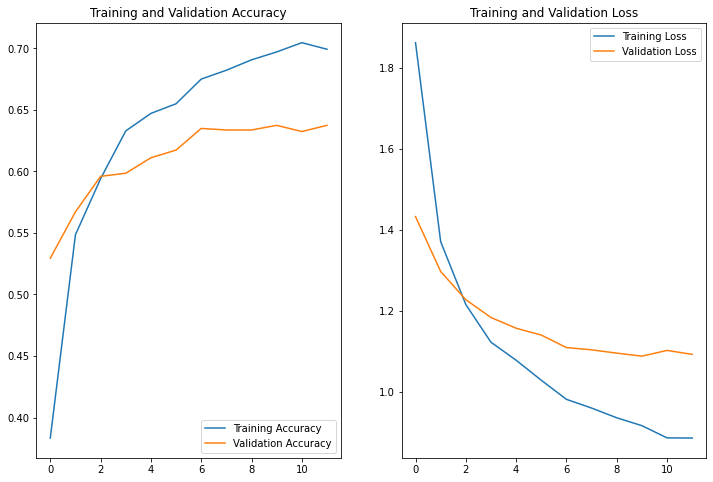

In [13]:
import helper_functions

helper_functions.visualize_training_progress(history.history, len(history.epoch))

1/1 [==============================] - 3s 3s/step


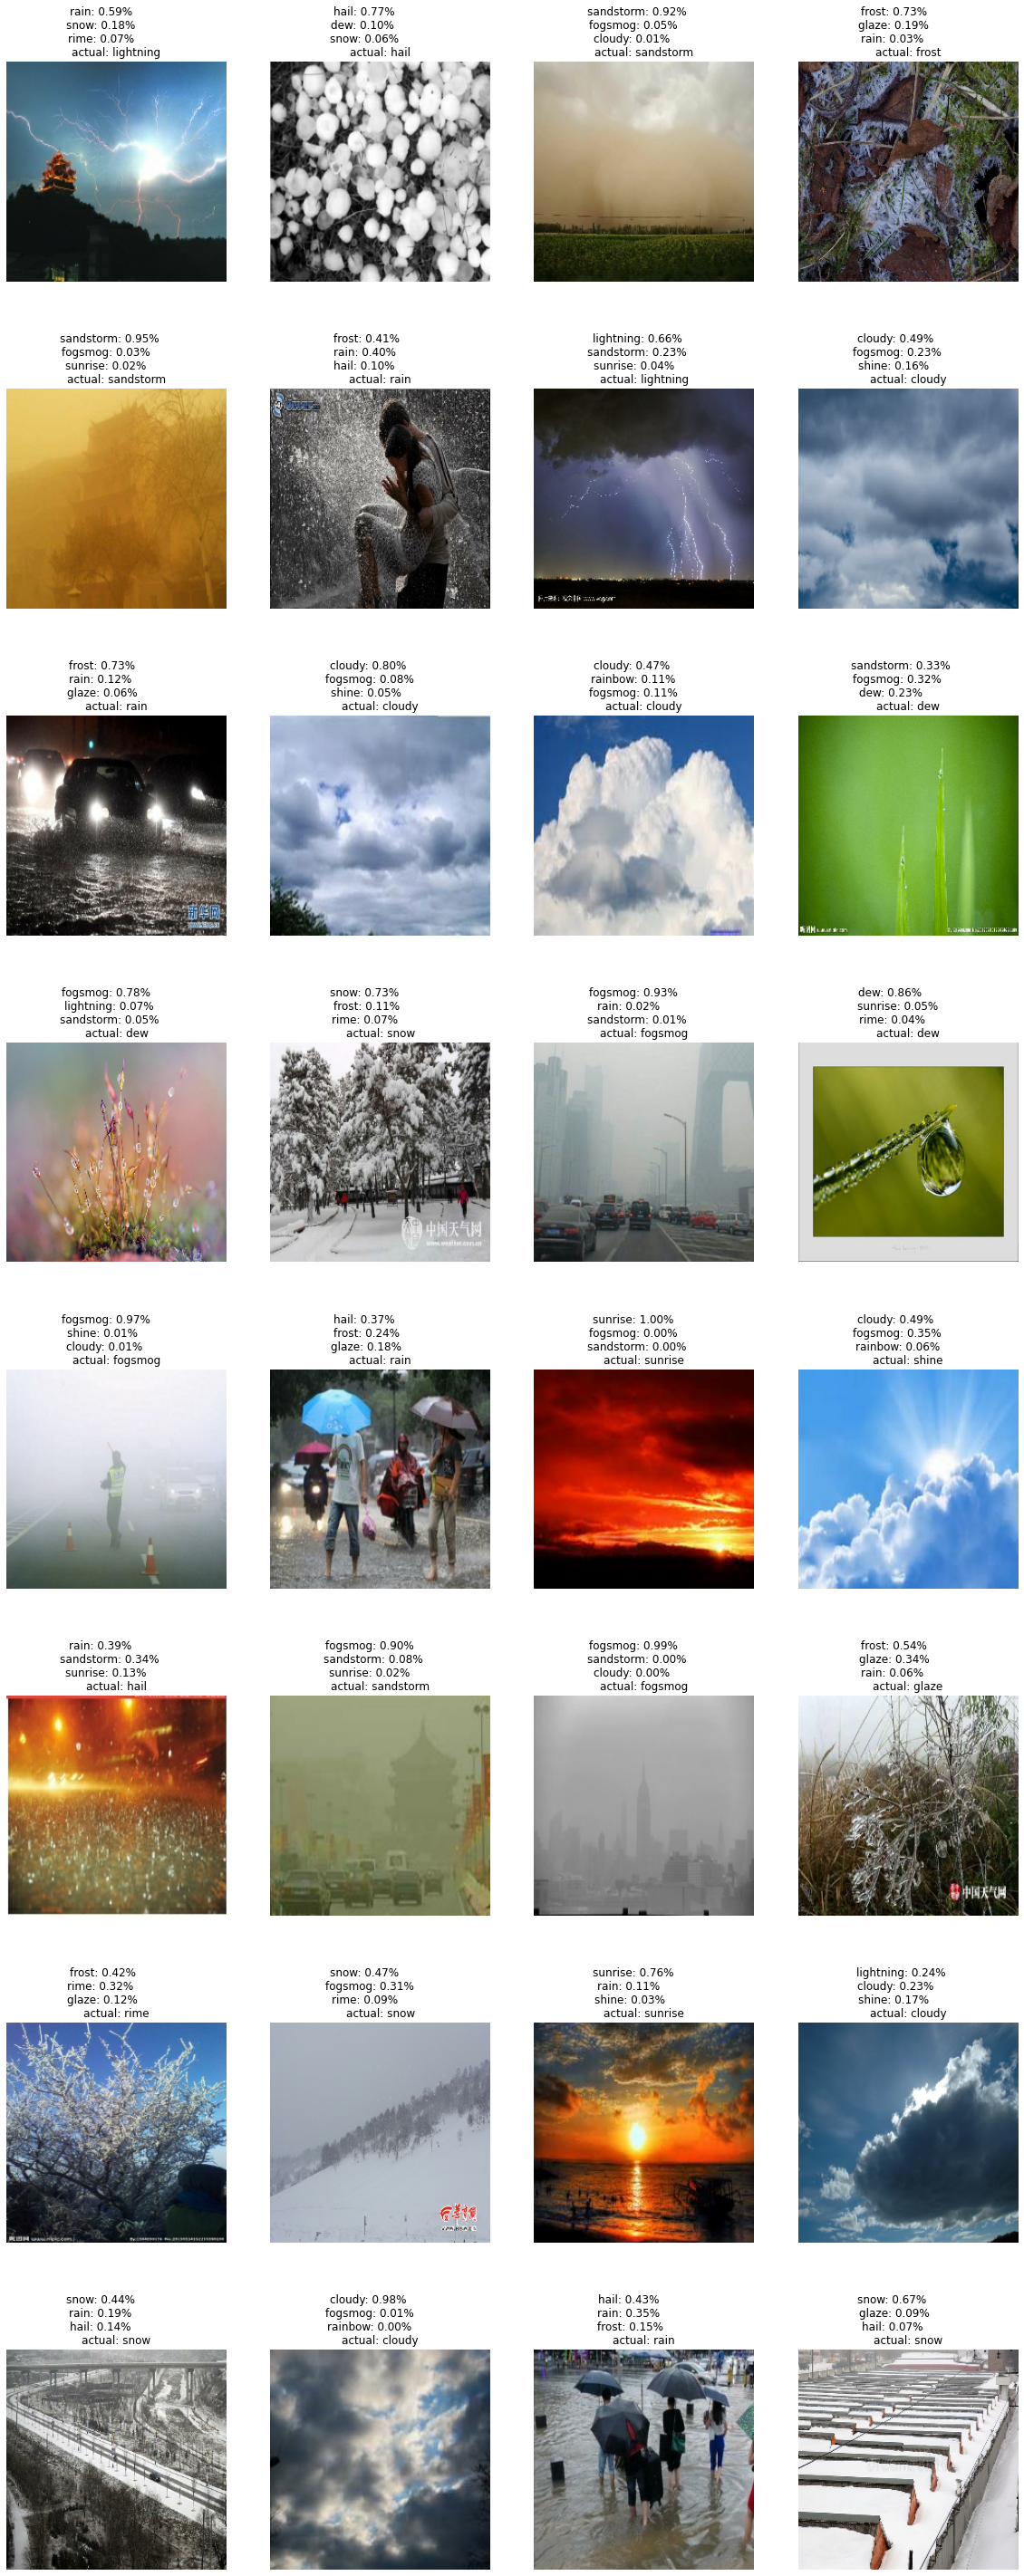

In [18]:
batch_images, batch_labels = next(iter(test_data))
transfermodel_predictions = transfermodel.predict(batch_images)
transfermodel_top_predictions = helper_functions.get_top_predictions(3, transfermodel_predictions)
helper_functions.visualize_evaluation(transfermodel_top_predictions, batch_images, batch_labels)